### 1. Introduction
### Warning! This class uses GPU.
### In this program, we write a class which we call Fisherinator that can take as input 
1. The 5PNAAK base parameters {M, mu, a, p0, e0, Y0, dist, qS, phiS, qK, phiK, Phi_phi0, Phi_theta0, Phi_r0, dt, T}
2. A list param_names in which the order of parameters in which the Fisher matrix is desired is provided.
3. deltas (default = None) as an input dict
4. CovMat = True or False
5. CovEllipse = True or False
6. filename (default = ''). If provided, we save the Fisher matrix and the covariance ellipse plots using this filename.


### and generates the following:
1. If Check_Stability = True, produce the deltas correpsonding to the most stable value of the Fisher elements, $\Gamma_{i,i} = \left<\partial_\theta_i h | \partial_\theta_i h \right>$ 1.1 If Check_Stability = False, an np.array of the size of the extrinsic param set (8) must be provided.
2. Using these deltas, the inner product code, and the 8th-order finite-difference derivative code, calculate the full 8x8 Fisher matrix corresponding to the extrinsic parameter set. 
3. If CovMat = True, also produce a covariance matrix corresponding to the calculated Fisher matrix
4. If CovEllipse = True, produce a covariance matrix, and produce a matplotlib plot of the covariance ellipse for the extrinsic parameter set. 

### The code after class definition is for basic testing and usage guidance. 

In [1]:
#imports

import os
from matplotlib import pyplot as plt
import numpy as np
import time
import sys
from cupy.fft import rfft, rfftfreq
import cupy as cp

#=== 5PN AAK imports ================

from few.trajectory.inspiral import EMRIInspiral
from few.amplitude.romannet import RomanAmplitude
from few.amplitude.interp2dcubicspline import Interp2DAmplitude
from few.waveform import FastSchwarzschildEccentricFlux, SlowSchwarzschildEccentricFlux, GenerateEMRIWaveform
from few.utils.utility import (get_overlap, 
                               get_mismatch, 
                               get_fundamental_frequencies, 
                               get_separatrix, 
                               get_mu_at_t, 
                               get_p_at_t, 
                               get_kerr_geo_constants_of_motion,
                               xI_to_Y,
                               Y_to_xI)

from few.utils.ylm import GetYlms
from few.utils.modeselector import ModeSelector
from few.summation.interpolatedmodesum import CubicSplineInterpolant
from few.waveform import SchwarzschildEccentricWaveformBase
from few.summation.interpolatedmodesum import InterpolatedModeSum
from few.summation.directmodesum import DirectModeSum
from few.utils.constants import *
from few.summation.aakwave import AAKSummation
from few.waveform import Pn5AAKWaveform, AAKWaveformBase

In [7]:
#supporting functions defined outside
#defining Sensitivity curve (for 1 year) 
def sensitivity(f):
    
    #Defining supporting functions
    L = 2.5e9 #m
    fstar = 19.09e-3 #Hz
    
    P_OMS = (1.5e-11**2)*(1+(2e-3/f)**4) #Hz-1
    P_acc = (3e-15**2)*(1+(0.4e-3/f)**2)*(1+(f/8e-3)**4) #Hz-1
    
    #S_c changes depending on signal duration (Equation 14 in 1803.01944)
    #for 1 year
    alpha = 0.171
    beta = 292
    kappa = 1020
    gamma = 1680
    fk = 0.00215
    #log10_Sc = (np.log10(9)-45) -7/3*np.log10(f) -(f*alpha + beta*f*np.sin(kappa*f))*np.log10(np.e) + np.log10(1 + np.tanh(gamma*(fk-f))) #Hz-1 
    
    A=9e-45
    Sc = A*f**(-7/3)*np.exp(-f**alpha+beta*f*np.sin(kappa*f))*(1+np.tanh(gamma*(fk-f)))
    
    return (10/(3*L**2))*(P_OMS+4*(P_acc)/((2*np.pi*f)**4))*(1 + 6*f**2/(10*fstar**2))+Sc
    
#Defining the inner product (this runs on the GPU)
def inner_product(a,b,dt=10):
    #Taking the FFTs of a and b
    n = max((len(a),len(b)))
    f = rfftfreq(n)/dt
    df = 1/(n*dt)
    atilde_real = rfft(a.real*dt, n=n)[1:]
    btilde_real = rfft(b.real*dt, n=n)[1:]

    plus_prod = cp.conj(atilde_real)@(btilde_real/sensitivity(f[1:]))

    atilde_imag = rfft(a.imag*dt, n=n)[1:]
    btilde_imag = rfft(b.imag*dt, n=n)[1:]

    cross_prod = cp.conj(atilde_imag)@(btilde_imag/sensitivity(f[1:]))
    return 4*df*cp.real(plus_prod+cross_prod)

#defining the function for plotting the covariance ellipses

from matplotlib.patches import Ellipse
from matplotlib import transforms

def cov_ellipse(mean, cov, ax, n_std=1.0, edgecolor='blue',facecolor='none',lw=5, **kwargs):

    pearson = cov[0, 1]/np.sqrt(cov[0, 0] * cov[1, 1])
    #print(pearson)
    ell_radius_x = np.sqrt(1 + pearson)
    ell_radius_y = np.sqrt(1 - pearson)
    ellipse = Ellipse((0, 0),
        width=ell_radius_x * 2,
        height=ell_radius_y * 2,
        edgecolor=edgecolor,
        facecolor=facecolor,
        lw = lw,
        **kwargs)

    scale_x = np.sqrt(cov[0, 0]) * n_std
    mean_x = mean[0]

    scale_y = np.sqrt(cov[1, 1]) * n_std
    mean_y = mean[1]

    transf = transforms.Affine2D() \
        .rotate_deg(45) \
        .scale(scale_x, scale_y) \
        .translate(mean_x, mean_y)

    ellipse.set_transform(transf + ax.transData)
    return ax.add_patch(ellipse)

#=============================================================

class Fisherinator:
    
    def __init__(self, M, mu, a, p0, e0, Y0, dist, qS, phiS, qK, phiK,\
                 Phi_phi0, Phi_theta0, Phi_r0, dt = 10, T = 1, param_names=[],\
                 deltas=None, CovMat=False, CovEllipse=False, filename=''):
        
        #Basic Consistency Check
        if deltas != None and len(deltas) != 14:
            sys.exit('Length of deltas array should be equal to the no. of 5PNAAK parameters.')
        
        #initializing param_names list
        if len(param_names) == 0:
            self.param_names = ['M','mu','a','p0','e0','Y0','dist','qS','phiS',\
                            'Phi_phi0', 'Phi_phi0-Phi_theta0','Phi_phi0-Phi_r0',\
                            'qK','phiK']
            
        elif len(param_names) != 14:
            print('Warning! Lenght of param_names must be equal to the no. of 5PNAAK parameters.\n\
                   Assuming default order of parameters.')
            
            self.param_names = ['M','mu','a','p0','e0','Y0','dist','qS','phiS',\
                            'Phi_phi0', 'Phi_phi0-Phi_theta0','Phi_phi0-Phi_r0',\
                            'qK','phiK']
            
        elif len(param_names) == 14:
            self.param_names = param_names
        
        #initializing FEW
        #defining model parameters

        use_gpu = True

        # keyword arguments for inspiral generator (RunKerrGenericPn5Inspiral)
        inspiral_kwargs = {
            "DENSE_STEPPING": 1,  # we want a sparsely sampled trajectory
            "max_init_len": int(1e4),  # all of the trajectories will be well under len = 1000
        }

        # keyword arguments for summation generator (AAKSummation)
        sum_kwargs = {
            "use_gpu": use_gpu,  # GPU is availabel for this type of summation
            "pad_output": False,
        }

        self.wave_generator = Pn5AAKWaveform(inspiral_kwargs=inspiral_kwargs, sum_kwargs=sum_kwargs, use_gpu=use_gpu)

        
        #initializing parameters
        self.M = M
        self.mu = mu
        self.a = a
        self.p0 = p0
        self.e0 = e0
        self.Y0 = Y0
        self.dist = dist
        self.qS = qS
        self.phiS = phiS
        self.qK = qK
        self.phiK = phiK
        self.Phi_phi0 = Phi_phi0
        self.Phi_theta0 = Phi_theta0
        self.Phi_r0 = Phi_r0
        self.dt = dt
        self.T = T
        
        #initializing param dictionary
        self.param = {'M':M,\
                      'mu':mu,\
                      'a':a,\
                      'p0':p0,\
                      'e0':e0,\
                      'Y0':Y0,\
                      'dist':dist,\
                      'qS':qS,\
                      'phiS':phiS,\
                      'Phi_phi0':Phi_phi0,\
                      'Phi_phi0-Phi_theta0':Phi_phi0-Phi_theta0,\
                      'Phi_phi0-Phi_r0':Phi_phi0-Phi_r0,\
                      'qK':qK,\
                      'phiK':phiK
                      }
        
        #initializing deltas
        self.deltas = deltas #Use deltas == None as a Flag
        
        #initializing other Flags:
        self.CovMat = CovMat
        self.CovEllipse = CovEllipse
        self.filename = filename
        
    def __call__(self):
        
        #generating the waveform
        self.waveform = self.wave_generator(M=self.M, mu=self.mu, a=self.a, p0=self.p0, e0=self.e0, Y0=self.Y0, \
                                  qS = self.qS, phiS = self.phiS, qK = self.qK, phiK = self.phiK, dist = self.dist, \
                                  Phi_phi0=self.Phi_phi0, Phi_theta0=self.Phi_theta0, Phi_r0=self.Phi_r0, mich=True, dt=self.dt, T=self.T)
        rho = np.sqrt(inner_product(self.waveform,self.waveform,dt=self.dt)).real
        print('Waveform Generated. SNR: ', rho)
        
        #Performing tasks chronologically
        
        #1. If deltas not provided, calculating the stable deltas
        if self.deltas == None:
            self.Fisher_Stability() #generates self.deltas
        
        #2. Given the deltas, we calculate the Fisher Matrix
        Fisher = self.FisherCalc()
        
        #3. If demanded, calculate the covariance Matrix
        if self.CovMat:
            covariance = np.linalg.inv(Fisher)
        else: 
            covariance = []
            
        if self.CovEllipse:
            covariance = np.linalg.inv(Fisher)
            self.CovEllipsePlot(covariance)
            
        return Fisher, covariance
    
    #Now, we define the functions being used by the class
    
    #defining the derivative function
    def derivative(self, i, delta):
        #modifying the given parameter
        temp = self.param.copy()

        temp[self.param_names[i]] += delta
        print(self.param_names[i],' = ', temp[self.param_names[i]])

        waveform_plus = self.wave_generator(M=temp['M'],\
                    mu = temp['mu'],\
                    a = temp['a'],\
                    p0 = temp['p0'],\
                    e0 = temp['e0'],\
                    Y0 = temp['Y0'],\
                    qS = temp['qS'],\
                    phiS = temp['phiS'],\
                    qK = temp['qK'],\
                    phiK = temp['phiK'],\
                    dist = temp['dist'],\
                    Phi_phi0=temp['Phi_phi0'],\
                    Phi_theta0=-temp['Phi_phi0-Phi_theta0']+temp['Phi_phi0'],\
                    Phi_r0=-temp['Phi_phi0-Phi_r0']+temp['Phi_phi0'],\
                    mich=True,\
                    T = self.T,\
                    dt = self.dt
                    )

        temp = self.param.copy()

        temp[self.param_names[i]] -= delta

        waveform_minus = self.wave_generator(M=temp['M'],\
                    mu = temp['mu'],\
                    a = temp['a'],\
                    p0 = temp['p0'],\
                    e0 = temp['e0'],\
                    Y0 = temp['Y0'],\
                    qS = temp['qS'],\
                    phiS = temp['phiS'],\
                    qK = temp['qK'],\
                    phiK = temp['phiK'],\
                    dist = temp['dist'],\
                    Phi_phi0=temp['Phi_phi0'],\
                    Phi_theta0=-temp['Phi_phi0-Phi_theta0']+temp['Phi_phi0'],\
                    Phi_r0=-temp['Phi_phi0-Phi_r0']+temp['Phi_phi0'],\
                    mich=True,\
                    T = self.T,\
                    dt = self.dt
                    )


        #padding waveforms with zeros in the end in case of early plunge than the original waveform
        if len(waveform_plus) < len(self.waveform):
            waveform_plus = cp.concatenate((waveform_plus,cp.zeros(len(self.waveform)-len(waveform_plus), dtype=cp.complex64)))

        elif len(waveform_plus) > len(self.waveform):
            waveform_plus = waveform_plus[:len(self.waveform)]

        if len(waveform_minus) < len(self.waveform):
            waveform_minus = cp.concatenate((waveform_minus,cp.zeros(len(self.waveform)-len(waveform_minus), dtype=cp.complex64)))

        elif len(waveform_minus) > len(self.waveform):
            waveform_minus = waveform_minus[:len(self.waveform)]

        #2nd order finite difference differentiation
        derivative = (waveform_plus - waveform_minus)/(2*delta)

        del waveform_plus
        del waveform_minus

        return derivative
    
    
    #defining Fisher_Stability function, generates self.deltas
    def Fisher_Stability(self):
        print('calculating stable deltas...')
        Ndelta = 12
        delta_init = np.geomspace(1e-2,1e-8,Ndelta)

        deltas = {}

        for i in range(len(self.param_names)):
            Gamma = []

            for k in range(Ndelta):
                del_k = self.derivative(i, delta_init[k])

                #Calculating the Fisher Elements
                Gammai = inner_product(del_k,del_k,dt=self.dt)
                print(Gammai)
                Gamma.append(Gammai)

            Gamma = cp.asnumpy(cp.array(Gamma))

            relerr = np.abs(Gamma[1:] - Gamma[:-1])/Gamma[1:]
            print(relerr)
            relerr_min_i, = np.where(np.isclose(relerr, np.min(relerr),rtol=1e-1*np.min(relerr),atol=1e-1*np.min(relerr)))
            print(relerr_min_i)

            deltas[self.param_names[i]] = np.float64(delta_init[relerr_min_i])
            
        print('stable deltas: ', deltas)
        self.deltas = deltas
            
        
    #defining FisherCalc function, returns Fisher
    def FisherCalc(self):
        print('calculating Fisher matrix...')
        Fisher = np.zeros((len(self.param_names),len(self.param_names)),dtype = np.float64)

        dtv = cp.zeros((len(self.param_names),len(self.waveform)),dtype=np.complex64)

        for i in range(len(self.param_names)):
            dtv[i] = self.derivative(i, self.deltas[self.param_names[i]])

        for i in range(len(self.param_names)):
            for j in range(i,len(self.param_names)):
                #compute the diagonal Gamma
                Fisher[i,j] = np.float64(cp.asnumpy(inner_product(dtv[i],dtv[j],dt=self.dt).real))

                #Exploiting symmetric property of the Fisher Matrix
                Fisher[j,i] = Fisher[i,j]
                
        if self.filename == '':
            pass
        else:
            np.savetxt('Fisher14D_'+self.filename+'.txt',Fisher)
            
        return Fisher

    
    #defining CovEllipsePlot function, produces Matplotlib plot
    #for the generated covariance matrix
    
    def CovEllipsePlot(self, covariance):
        print('plotting covariance ellipses...')
        
        fig, axs = plt.subplots(len(self.param_names),len(self.param_names),figsize=(20,20))

        #first param index
        for i in range(len(self.param_names)):
            #second param index
            for j in range(i+1,len(self.param_names)):

                cov = np.array(((covariance[i][i],covariance[i][j]),(covariance[j][i],covariance[j][j])))
                #print(cov)
                mean = np.array((self.param[self.param_names[i]],self.param[self.param_names[j]]))

                cov_ellipse(mean,cov,axs[j,i],lw=2)

                #custom setting the x-y lim for each plot
                axs[j,i].set_xlim([self.param[self.param_names[i]]-2.5*np.sqrt(covariance[i][i]), self.param[self.param_names[i]]+2.5*np.sqrt(covariance[i][i])])
                axs[j,i].set_ylim([self.param[self.param_names[j]]-2.5*np.sqrt(covariance[j][j]), self.param[self.param_names[j]]+2.5*np.sqrt(covariance[j][j])])

                axs[j,i].set_xlabel(self.param_names[i],labelpad=20)
                axs[j,i].set_ylabel(self.param_names[j],labelpad=20)

        for ax in fig.get_axes():
            ax.label_outer()

        for i in range(len(self.param_names)):
            for j in range(i,len(self.param_names)):
                fig.delaxes(axs[i,j])
                
        if self.filename == '':
            pass
        else:
            plt.savefig('CovEllipse14D_'+self.filename+'.png',dpi=300,bbox_inches='tight')
        
    
    

### Fisherinator definition is complete. We can now play with it. Demo code is provided herewith.

Waveform Generated. SNR:  37.354606361261936
calculating Fisher matrix...
M  =  1000000.01
mu  =  10.000000123284673
a  =  0.9000000351119174
p0  =  8.100000035111917
e0  =  0.10000003511191735
Y0  =  0.5403023409800571
dist  =  1.0000053366992312
qS  =  0.2000053366992312
phiS  =  0.2000187381742286
Phi_phi0  =  2.0002310129700085
Phi_phi0-Phi_theta0  =  -0.9997689870299917
Phi_phi0-Phi_r0  =  0.5002310129700083
qK  =  0.8000657933224657
phiK  =  0.8000187381742286
plotting covariance ellipses...
CPU times: user 2min 38s, sys: 3.88 s, total: 2min 42s
Wall time: 2min 27s


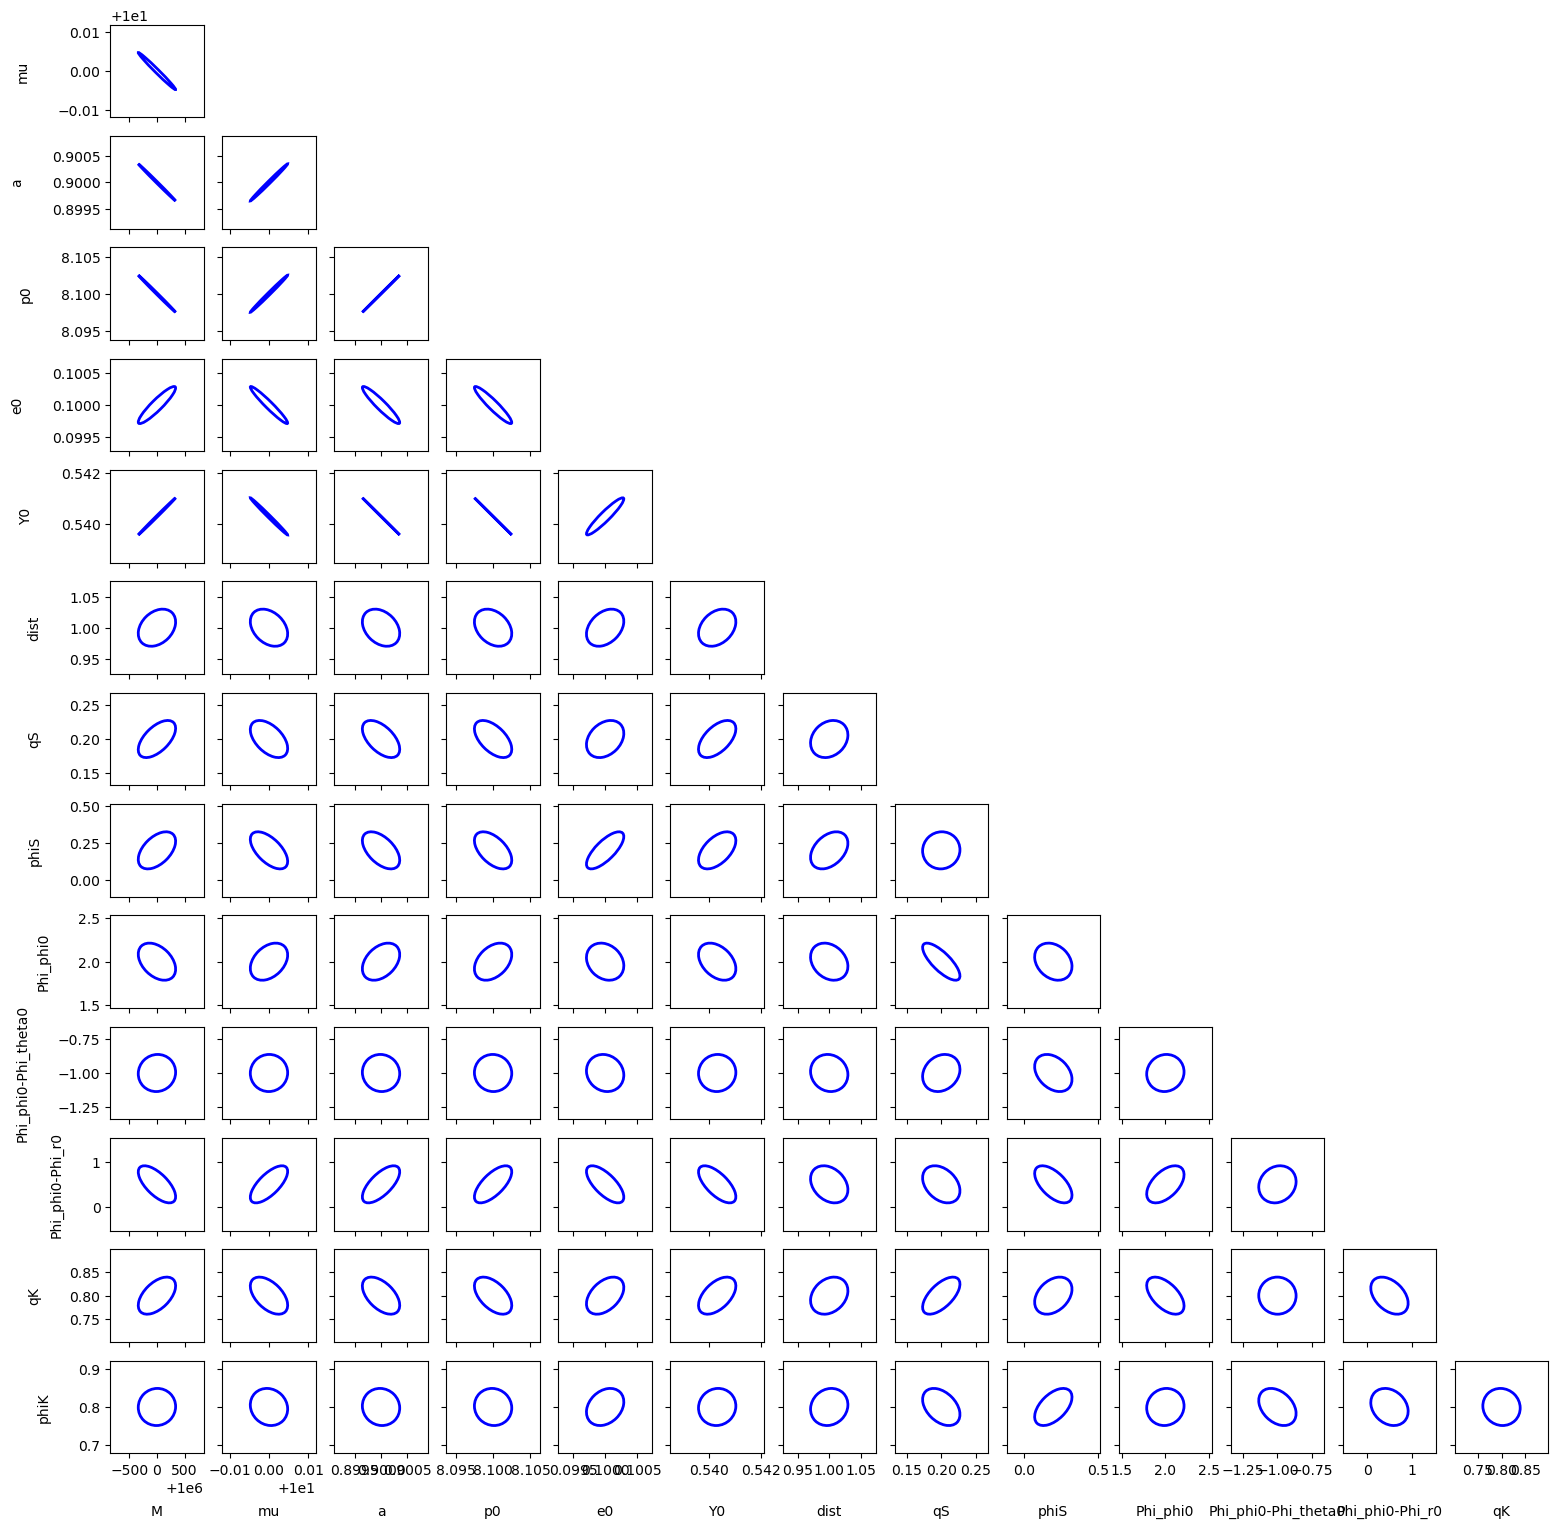

In [4]:
%%time

#set initial parameters (default parameters in FEW 5PNAAK Documentation)
M = 1e6
mu = 1e1
a = 0.9
e0 = 0.1
iota0 = 1
Y0 = np.cos(iota0)
Phi_phi0 = 2
Phi_theta0 = 3
Phi_r0 = 1.5
p0 = 8.1
#p0 = get_p_at_t(traj, 1, [M, mu, a, e0, Y0])
#print(p0)

qS = 0.2
phiS = 0.2
qK = 0.8
phiK = 0.8
dist = 1.0
mich = True #mich = True implies output in hI, hII long wavelength approximation
dt = 10.0
T = 0.9

#initialization
fish = Fisherinator(M, mu, a, p0, e0, Y0, dist, qS, phiS, qK, phiK,\
            Phi_phi0, Phi_theta0, Phi_r0, dt, T, \
            deltas={'M': 0.01, 'mu': 1.2328467394420683e-07, 'a': 3.511191734215134e-08,\
                    'p0': 3.511191734215134e-08, 'e0': 3.511191734215134e-08, \
                    'Y0': 3.511191734215134e-08, 'dist': 5.336699231206313e-06, \
                    'qS': 5.336699231206313e-06, 'phiS': 1.8738174228603867e-05, \
                    'Phi_phi0': 0.00023101297000831605, 'Phi_theta0': 0.00023101297000831605,\
                    'Phi_phi0-Phi_r0': 0.00023101297000831605, 'qK': 6.579332246575683e-05,\
                    'phiK': 1.8738174228603867e-05},#can comment\
            CovMat=True, #can comment\
            CovEllipse=True,  #can comment\
            filename='test',#can comment\
            #param_names = ['dist','qS','phiS','Phi_phi0','Phi_theta0','Phi_phi0-Phi_r0','qK','phiK'] #can comment
            )

#execution 
Fisher, covariance = fish()